In [2]:
'''
    This program processes a JSON file of earthquake data from the USGS website amd returns three outputs
    1) a table showing the average magnitude and significance for each alert category of earthquake, and number of quakes in that category
    2) a scatterplot of the magnitude and significance of each earthquake in the dataset, colored by alert category
    3) a grouped bar chart of the average number of felt reports submitted by alert type and tsunami possibility
    
    Significant event earthquakes have a significance score greater than 600, however, all earthquakes are included in the dataset and the significance score is a field of data used in analysis.
    
    Alert categories are from the alert level from the PAGER earthquake impact scale and can include values: green, yellow, orange and red. 
    The PAGER earthquake impact scale provides fatality and economic loss impact estimates following significant earthquakes worldwide.

    A felt report is submitted to the DYFI (Did You Feel It?) system and is data collected from people who felt an earthquake.
    The Tsunami flag is not the same as a tsunami warning. Tsunami warnings are performed by NOAA. The flag simply notes events in oceanic regions where there is a possibility of tsunami.
    
    The Mongo server must be running.
    The results are written to a csv file or jpg.
    The program uses pandas dataframes to represent the analysis tables.
'''

'\n    This program processes a JSON file of earthquake data from the USGS website amd returns three outputs\n    1) a table showing the average magnitude and significance for each alert category of earthquake, and number of quakes in that category\n    2) a scatterplot of the magnitude and significance of each earthquake in the dataset, colored by alert category\n    3) a grouped bar chart of the average number of felt reports submitted by alert type and tsunami possibility\n    \n    Significant event earthquakes have a significance score greater than 600, however, all earthquakes are included in the dataset and the significance score is a field of data used in analysis.\n    (In class activities only worked with the significant earthquakes dataset, but this analysis uses the all earthquake json file.)\n    \n    Alert categories are from the alert level from the PAGER earthquake impact scale and can include values: green, yellow, orange and red. \n    The PAGER earthquake impact sca

In [3]:
#Import the necessary libraries
import json
import pymongo
import pandas as pd
import urllib.request 
import datetime
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
#direct to the URL that has the data and read data
#I am using all month data vs. significant month data to meet the requirements of the assignment of a dataset with a few hundred records 
quake_url = "http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.geojson" 

In [5]:
#fetch the URL with urllib and read data into string
data = urllib.request.urlopen(quake_url)
string = data.read().decode('utf-8')
#Parse the string into a python dictionary
parsed_json = json.loads(string) 

In [6]:
#find out the keys in the dictionary
parsed_json.keys()

dict_keys(['type', 'metadata', 'features', 'bbox'])

In [7]:
#take a peek at a record so I know what fields I can work with
quakelist = parsed_json['features']
quakelist[0] #just look at the first record

{'type': 'Feature',
 'properties': {'mag': 1.6,
  'place': '22 km NE of Beluga, Alaska',
  'time': 1653580309721,
  'updated': 1653580455857,
  'tz': None,
  'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/ak0226ppp7j0',
  'detail': 'https://earthquake.usgs.gov/earthquakes/feed/v1.0/detail/ak0226ppp7j0.geojson',
  'felt': None,
  'cdi': None,
  'mmi': None,
  'alert': None,
  'status': 'automatic',
  'tsunami': 0,
  'sig': 39,
  'net': 'ak',
  'code': '0226ppp7j0',
  'ids': ',ak0226ppp7j0,',
  'sources': ',ak,',
  'types': ',origin,phase-data,',
  'nst': None,
  'dmin': None,
  'rms': 0.62,
  'gap': None,
  'magType': 'ml',
  'type': 'earthquake',
  'title': 'M 1.6 - 22 km NE of Beluga, Alaska'},
 'geometry': {'type': 'Point', 'coordinates': [-150.8291, 61.3034, 34.9]},
 'id': 'ak0226ppp7j0'}

In [8]:
#tell user how many records are being used in this dataset
print('Read in ',len(quakelist),' earthquakes for the month of data.')

Read in  8975  earthquakes for the month of data.


In [9]:
#again, the mongo server must be running for this program...
client = pymongo.MongoClient('localhost', 27017)

In [10]:
#use database named usgs or create it if not there already
eqdb = client.usgsnewDVL2
#use collection named quakecoll or create it if not there already
quakecoll = eqdb.earthquakes2

#drop the selected item do we aren't just appending the same data, again and again
eqdb.earthquakes2.drop()

In [11]:
#add all the earthquake data to the list
quakecoll.insert_many(quakelist)
quake_docs = quakecoll.find()

In [12]:
#loop through the data and grab variables I want in my dataframe and add it to a list
#note that time is listed in miliseconds in the data, and needs to be converted to a more readable format
qlist =[] #first create an empty list
for doc in quake_docs: #then use loop to pull out the variables I want
    place = doc["properties"]["place"]
    #unix timestamp in milliseconds
    unix_time_mil = doc["properties"]["time"]
    mag = doc["properties"]["mag"]
    alert = doc['properties']['alert']
    tsunami = doc['properties']['tsunami']
    felt = doc['properties']['felt']
    sig = doc['properties']['sig']
    # convert to unix in seconds
    unix_time = unix_time_mil / 1000
    time = datetime.datetime.fromtimestamp(unix_time).strftime('%Y-%m-%d %H:%M:%S') #covert time to a more readable format
    qlist.append([place,time,mag,alert,tsunami,felt,sig])  #append all the data to the empty list

In [13]:
#create the dataframe from the list created above
qdf = pd.DataFrame(qlist, columns=['Place','Time','Mag','Alert','Tsunami','Felt','Significance'])
#preview dataframe
qdf

,Place,Time,Mag,Alert,Tsunami,Felt,Significance
0,"22 km NE of Beluga, Alaska",2022-05-26 08:51:49,1.60,None,0,NaN,39
1,southeast of the Loyalty Islands,2022-05-26 08:37:58,6.40,green,1,0.0,630
2,"6 km SE of Pāhala, Hawaii",2022-05-26 08:26:09,1.87,None,0,NaN,54
3,"5 km SSE of Pāhala, Hawaii",2022-05-26 08:20:11,2.19,None,0,NaN,74
4,"11km SE of Cloverdale, CA",2022-05-26 08:06:40,1.75,None,0,NaN,47
...,...,...,...,...,...,...,...
8970,"58 km E of Iquique, Chile",2022-04-26 10:02:55,3.60,None,0,4.0,201
8971,"6 km N of Ridgeway, Alaska",2022-04-26 10:01:11,0.90,None,0,NaN,12
8972,"13 km NW of Four Mile Road, Alaska",2022-04-26 09:28:36,1.10,None,0,NaN,19
8973,"8km NW of The Geysers, CA",2022-04-26 09:22:10,0.36,None,0,NaN,2


In [14]:
#in reviewing the data, it appears that there is no data in Alert field for some of the records
#clean the data, to note the absence of alert flag in the dataframe
qdf['Alert'].fillna('None recorded', inplace = True)
qdf

,Place,Time,Mag,Alert,Tsunami,Felt,Significance
0,"22 km NE of Beluga, Alaska",2022-05-26 08:51:49,1.60,None recorded,0,NaN,39
1,southeast of the Loyalty Islands,2022-05-26 08:37:58,6.40,green,1,0.0,630
2,"6 km SE of Pāhala, Hawaii",2022-05-26 08:26:09,1.87,None recorded,0,NaN,54
3,"5 km SSE of Pāhala, Hawaii",2022-05-26 08:20:11,2.19,None recorded,0,NaN,74
4,"11km SE of Cloverdale, CA",2022-05-26 08:06:40,1.75,None recorded,0,NaN,47
...,...,...,...,...,...,...,...
8970,"58 km E of Iquique, Chile",2022-04-26 10:02:55,3.60,None recorded,0,4.0,201
8971,"6 km N of Ridgeway, Alaska",2022-04-26 10:01:11,0.90,None recorded,0,NaN,12
8972,"13 km NW of Four Mile Road, Alaska",2022-04-26 09:28:36,1.10,None recorded,0,NaN,19
8973,"8km NW of The Geysers, CA",2022-04-26 09:22:10,0.36,None recorded,0,NaN,2


In [15]:
#find the average magnitude and significance, and find the total number of earthquakes by alert type
#groupby alert type, apply mean to Mag and Significance, and count to Place
magqdf = qdf.groupby('Alert').agg({'Mag':'mean', 'Significance':'mean', 'Place':'count'})

#rename columns for clarity
magqdf.columns = ['Average Magnitude', 'Significance Score','Count of Earthquakes'] #remember that Alert is the index

print(magqdf.sort_values(by=['Count of Earthquakes'])) #make the sort low to high
magqdf.to_csv('Avg_Mag_By_Alert.csv') #create csv file of table


               Average Magnitude  Significance Score  Count of Earthquakes

Alert                                                                     

yellow                  5.400000          761.000000                     1

green                   5.565645          500.709677                    62

None recorded           1.493968           59.056216                  8912


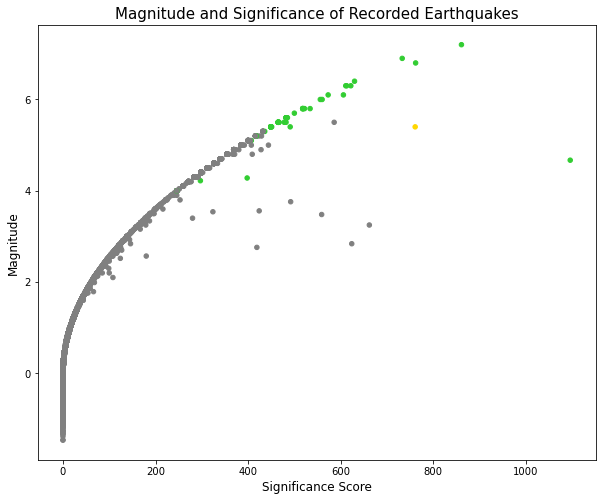

In [16]:
#graph magnitude and significance for a visual representation of the data
#color list for plots should be dependent on Alert value
colors = {'green':'limegreen', 'yellow': 'gold', 'None recorded': 'gray', 'orange': 'darkorange', 'red': 'firebrick'}
#set the parameters for the chart
plt.rcParams['figure.figsize'] = (10, 8)
mplot = qdf.plot.scatter('Significance', 'Mag', c=qdf['Alert'].map(colors)) #pick my variables and assign plot color to Alert categories
plt.title('Magnitude and Significance of Recorded Earthquakes', fontsize = 15) #title the chart
plt.xlabel('Significance Score', fontsize = 12) #label xaxis
plt.ylabel('Magnitude', fontsize = 12) #label yaxis
plt.savefig('Mag_And_Sig.jpg') #save as a jpg file
plt.show()

In [17]:
#felt reports may be more common in areas with larger populations
#larger populations tend to live near coastlines
#the presence of a coastline may trigger a tsunami potential
#examine records with Tsunami potential associated and minimum and maximum felt reports in each alert category
tsuqdf = (qdf.pivot_table(index='Tsunami', columns = 'Alert', values = 'Felt', aggfunc = ['mean'], fill_value=0))
tsuqdf

mean                  
Alert   None recorded      green yellow
Tsunami                                
0           33.324752  67.787879    156
1           24.000000  35.800000      0

AxesSubplot(0.125,0.125;0.775x0.755)


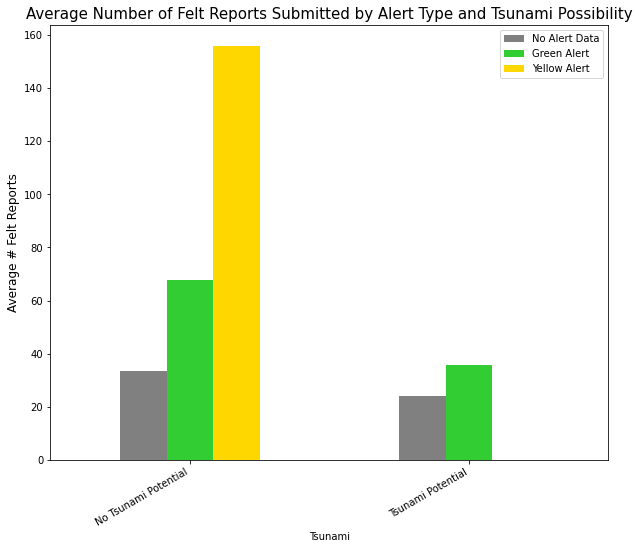

In [18]:
#graph the table for visual representation
plt.rcParams['figure.figsize'] = (10, 8) #set the parameters for the chart
tplot = tsuqdf.plot.bar(stacked=False, color = ('gray', 'limegreen', 'gold','darkorange', 'firebrick')) #select colors to match the alert categories
labels = ['No Tsunami Potential', 'Tsunami Potential'] #set labels for bar grouping
leglabs = ['No Alert Data', 'Green Alert', 'Yellow Alert','Orange Alert', 'Red Alert'] #labels for bars
tplot.legend(leglabs)
tplot.set_ylabel('Average # Felt Reports', fontsize = 12) #y axis label
tplot.set_title('Average Number of Felt Reports Submitted by Alert Type and Tsunami Possibility', fontsize = 15) #set title for chart
tplot.set_xticklabels(labels, rotation = 30, ha='right')
print(tplot)
plt.savefig('Avg_Felt_By_Tsunami_And_Alert.jpg') #save as a jpg file
